In [ ]:
!pip install bcolz

In [ ]:
import os
import math
import random
import time

import bcolz
import numpy as np
import pickle
import torch
from torch import nn
from torch import optim
from sklearn.model_selection import train_test_split
import nltk

from matplotlib import pyplot as plt

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#@title Mount to Google Drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
glove_path = os.path.join('drive', 'My Drive', 'eecs595_p/working_directory')
data_path = os.path.join('drive', 'My Drive', 'eecs595_p/data')
input_file = os.path.join(data_path, 'classification-test-sample.txt')

Mounted at /content/drive


In [ ]:
#@title Glove

from typing import Dict, List

class Glove():
    """Pre-trained word embedding."""

    def __init__(self):
        # These pickle are saved by executing cache_glove.py
        self.vectors = bcolz.open(f'{glove_path}/6B.50.dat')[:]
        self.word2idx = pickle.load(open(f'{glove_path}/6B.50_idx.pkl', 'rb'))

        # UNKA (the unkonwn word) is assigned an average word embedding
        # We have already checked that unka does not occur in glove
        self.word2idx['unka'] = self.vectors.shape[0]
        self.vectors = np.concatenate((self.vectors, np.matrix(self.vectors).mean(axis=0)))

        # PAD is for padding.
        self.word2idx['pad'] = self.vectors.shape[0]
        self.vectors = np.concatenate((self.vectors, np.zeros_like(self.vectors[0])))

    def observe_word_count(self, word_count: Dict[str, int]):
        """Informs Glove of the word count in the train data.

        Words that are not seen frequently enough in the train data will be treated as unka.
        The threshold is set to 3.
        """
        infrequent_words = []
        for word in self.word2idx:
            if word != 'pad' and word in word_count and word_count[word] < 3:
                infrequent_words.append(word)

        for word in infrequent_words:
            self.word2idx.pop(word)

    def get_word_indices(self, words: List[str]) -> np.ndarray:
        """Return word indices for teh given listo f words as a Numpy array."""
        indices = []
        for word in words:
            word = word.lower()
            if word in self.word2idx:
                indices.append(self.word2idx[word])
            else:
                indices.append(self.word2idx['unka'])
        return np.array(indices)

    def get_word_embeddings(self, word_indices: np.ndarray) -> np.ndarray:
        """Return the word embeddings for the given list of words.
        
        The word_indices could be a matrix.
        """
        return self.vectors[word_indices]

def embed_with_glove(tokenized):
    if len(tokenized) > 20:
        tokenized = tokenized[:20]
    elif len(tokenized) < 20:
        tokenized.extend(['pad'] * (20 - len(tokenized)))
    return glove.get_word_embeddings(glove.get_word_indices(tokenized))

In [ ]:
#@title Data and DataManager
class BatchDataManager():
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.data_size = len(self.y)
        self.batch_size = batch_size

    def getX(self, batch_idx: int) -> torch.Tensor():
        left = int(self.batch_size * batch_idx)
        right = int(min(self.batch_size * (batch_idx + 1), self.data_size))
        return self.X[left:right]

    def getY(self, batch_idx: int) -> torch.Tensor():
        left = self.batch_size * batch_idx
        right = min(self.batch_size * (batch_idx + 1), self.data_size)
        return self.y[left:right]

    def get_batch_num(self):
        """Return the total number of batches."""
        return math.ceil(len(self.y) / batch_size)


def read_data(catagory1, catagory2, limit=50000):
    catagory_files = [catagory1, catagory2]

    if limit == -1:
        line_count = 0
        for catagory_file in catagory_files:
            with open(catagory_file) as f:
                for line in f:
                    line_count += 1
    else:
        line_count = limit

    X = np.ndarray([line_count, 20, 50], dtype=float)
    y = np.ndarray([line_count], dtype=int)

    count = 0
    for catagory_idx, catagory_file in enumerate(catagory_files):
        if catagory_idx >= 2:
            raise RuntimeError('lalall')

        with open(catagory_file) as f:
            for line in f:
                y[count] = catagory_idx

                # Truncate or pad
                tokenized = line.lower().split()
                X[count] = embed_with_glove(tokenized)
                count += 1

                if catagory_idx == 0 and count >= line_count / 2:
                    break
                if catagory_idx == 1 and count >= line_count:
                    break
    return torch.tensor(X.astype(np.float32)), torch.tensor(y)


In [ ]:
glove = Glove()

catagory1 = os.path.join(data_path, 'positive_pop.txt')
catagory2 = os.path.join(data_path, 'negative_pop.txt')

X, y = read_data(catagory1, catagory2, limit=-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random.randint(0, 1000))
batch_manager_train = BatchDataManager(X_train, y_train, batch_size=32)
batch_manager_test = BatchDataManager(X_test, y_test, batch_size=32)

In [ ]:
#@title Classifier
class Classifier(nn.Module):
    def __init__(self,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        super().__init__()
        self.rnn = nn.GRU(50, #embedding_dim
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, embedded):
        _, hidden = self.rnn(embedded)
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        output = self.out(hidden)  
        return output

In [ ]:
#@title Training Helpers

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def train(model, batch_manager, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for j in range(batch_manager.get_batch_num()):
        optimizer.zero_grad()
        predictions = model(batch_manager.getX(j)).squeeze(1)
        loss = criterion(predictions, batch_manager.getY(j).float())
        acc = binary_accuracy(predictions, batch_manager.getY(j).float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / batch_manager.get_batch_num(), epoch_acc / batch_manager.get_batch_num()


def evaluate(model, batch_manager, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for j in range(batch_manager.get_batch_num()):
            predictions = model(batch_manager.getX(j)).squeeze(1)
            loss = criterion(predictions, batch_manager.getY(j).float())
            acc = binary_accuracy(predictions, batch_manager.getY(j).float())
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / batch_manager.get_batch_num(), epoch_acc / batch_manager.get_batch_num()


In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = Classifier(HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
batch_size = 32
N_EPOCHS = 5

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, batch_manager_train, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, batch_manager_test, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 13m 16s
	Train Loss: 0.374 | Train Acc: 82.82%
	 Val. Loss: 0.278 |  Val. Acc: 88.13%
Epoch: 02 | Epoch Time: 13m 10s
	Train Loss: 0.249 | Train Acc: 89.58%
	 Val. Loss: 0.243 |  Val. Acc: 89.79%
Epoch: 03 | Epoch Time: 13m 8s
	Train Loss: 0.203 | Train Acc: 91.64%
	 Val. Loss: 0.226 |  Val. Acc: 90.65%
Epoch: 04 | Epoch Time: 13m 10s
	Train Loss: 0.171 | Train Acc: 93.03%
	 Val. Loss: 0.226 |  Val. Acc: 91.06%
Epoch: 05 | Epoch Time: 13m 1s
	Train Loss: 0.145 | Train Acc: 94.06%
	 Val. Loss: 0.231 |  Val. Acc: 91.19%


In [ ]:
model_path = os.path.join(data_path, 'classifier.pt')

# Uncomment to save the model
# torch.save(model.state_dict(), model_path)

In [ ]:
loaded_model = Classifier(HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

Classifier(
  (rnn): GRU(50, 256, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (out): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
def get_score_for_sentences(tokenized):
    batch_size = len(tokenized)
    input = np.ndarray([batch_size, 20, 50], dtype=float)
    for i in range(batch_size):
        input[i] = embed_with_glove(tokenized[i])
    return loaded_model(torch.tensor(input.astype(np.float32)))

In [ ]:
import collections
import copy

class Stat():
    def __init__(self):
        self.count = 0
        self.sum = 0
      
    def append(self, score):
        self.count += 1
        self.sum += score
    
    def get_score(self):
        return self.sum / self.count

    def __repr__(self):
        return str(self.get_score())


def get_grams(text):
    grams = []
    for i in range(1, 5):
        i_grams = [" ".join(gram) for gram in nltk.ngrams(text, i)]
        grams.extend(i_grams)

        if len(i_grams) == 0:
            break
    return grams

def get_vocab(catagory_file):
    vocab = collections.defaultdict(Stat)
    count = 0
    batch_size = 256
    with open(catagory_file) as f:
        while True:
            lines = []
            for i in range(batch_size):
                line = f.readline()
                if not line:
                    break
                lines.append(line.lower().split())

            scores = get_score_for_sentences(copy.deepcopy(lines))
            for idx, tokenized in enumerate(lines):
                for gram in get_grams(tokenized):
                    vocab[gram].append(float(scores[idx]))
            count += 1
            if count % 50 == 0:
                print(count)
            if not line:
                break
    return vocab

In [ ]:
catagory1 = os.path.join(data_path, 'positive_pop.txt')
catagory2 = os.path.join(data_path, 'negative_pop.txt')
vocab1 = get_vocab(catagory1)
vocab2 = get_vocab(catagory2)

threshold = 10

shared_vocab = {}
for key in vocab1:
    if vocab1[key].count >= threshold:
        if key in vocab2 and vocab2[key].count >= threshold:
            shared_vocab[key] = (vocab1[key].get_score() + vocab2[key].get_score()) / 2

with open(os.path.join(data_path, 'classifier.attribute.txt'), 'w+') as f:
    for key in shared_vocab:
        score = shared_vocab[key]
        f.write(f'{key} {-score} {score}\n')

In [34]:
def get_scores_for_txt(filename):
    lines = []
    with open(filename) as f:
        for line in f:
            lines.append(line.lower().split())
    return get_score_for_sentences(lines).detach()[:,0]
  
def plot_hist(filename):
    scores = get_scores_for_txt(filename)
    plt.hist(- scores, bins=20, density=True)
    plt.xlabel('Classifier score')
    plt.ylabel('Probability Density')
    plt.show()

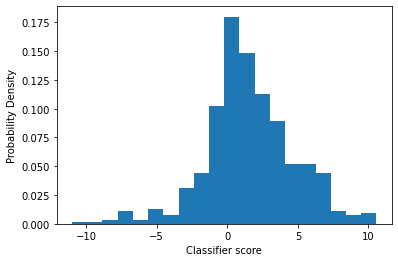

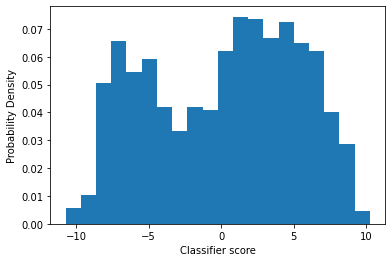

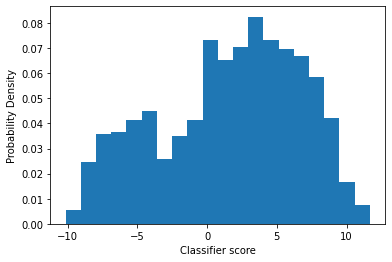

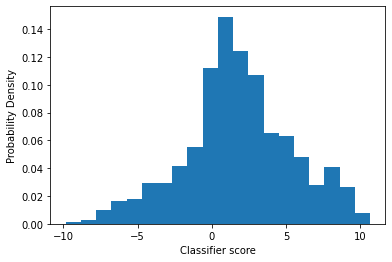

In [35]:
plot_hist(os.path.join('drive', 'My Drive', '595FinalProject/eva_lyrics/input.txt'))
plot_hist(os.path.join('drive', 'My Drive', '595FinalProject/eva_lyrics/preds_delete.txt'))
plot_hist(os.path.join('drive', 'My Drive', '595FinalProject/eva_lyrics/preds_delete_retrieve.txt'))
plot_hist(os.path.join('drive', 'My Drive', '595FinalProject/eva_lyrics/preds_classifier.txt'))